In [1]:
from dask_jobqueue import SLURMCluster

cluster = SLURMCluster(cores=1,
                       memory ='100GB',
                       walltime="12:00:00")


/srv/home/jwei74/anaconda3/lib/python3.9/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44579 instead
  warnings.warn(


In [10]:
import dask
print(dask.__version__)
import distributed
print(distributed.__version__)
import dask_jobqueue
print(dask_jobqueue.__version__)

2021.04.0
2021.04.0
0.7.3


In [ ]:
# Call at head node, otherwise you won't get the dashboard
from dask.distributed import Client
cluster.scale(1) # number of nodes you request
client = Client(cluster)
client

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.io
import time
import glob,os
from scipy import optimize
from skimage import feature
from pylab import *
import struct
import math
import sys

#from skimage import data, color
from scipy import ndimage
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny
from skimage.morphology import disk
from skimage.morphology import closing
from skimage.draw import circle_perimeter
from skimage.util import img_as_ubyte
from tqdm.notebook import tqdm, trange

sys.path.append('/srv/home/jwei74/hyperspy')
import hyperspy.api as hs
from hyperspy import io_plugins
from PIL import Image
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [3]:
import time
import SeqIO
from SeqIO.version import __version__
from SeqIO.CeleritasSeqReader import SeqReader
from SeqIO.utils.file_utils import read_ref
import pyxem
from pyxem.signals.diffraction2d import *

### Load and visualizing

Load multi-dimentional data: for dask array in SeqIO and numpy array, the shaping is [fc, nav, nav, pc]; for hyperspy, it's different, [pc, nav, nav, fc]

In [4]:
folder ='/srv/home/jwei74/4DSTEMdata/TwistedWS2/20211204/movie401/'
signal = SeqIO.load_folder(folder,lazy=True, chunk_shape=(1,256,256), nav_shape=(4,256,256))
signal.data


dask.array<get_image_chunk, shape=(4, 256, 256, 256, 256), dtype=float32, chunksize=(1, 256, 256, 256, 256), chunktype=numpy.ndarray>

In [5]:
# sum the frame cycle data to get better SNR for beam center
signal_sum = signal.sum(axis = 2)
signal_sum.data

dask.array<sum-aggregate, shape=(256, 256, 256, 256), dtype=float32, chunksize=(64, 64, 64, 64), chunktype=numpy.ndarray>

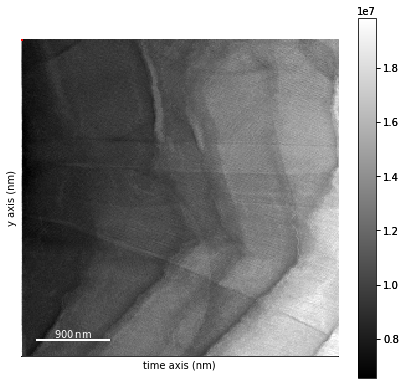

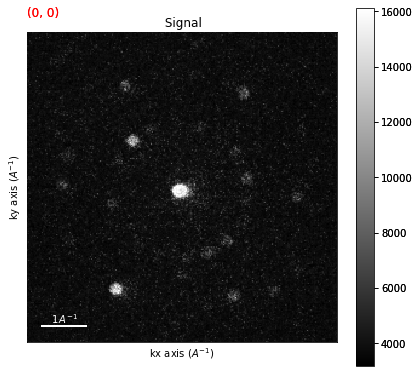

In [204]:
signal_sum.plot()

In [6]:
signal_sum.set_signal_type('electron_diffraction') # needed
#signal_sum.set_diffraction_calibration(0.027776)
signal_sum.compute()
#signal_slice.data[signal_slice.data<7] = 0
#signal_sum = signal_sum/241 # you cannot do the integration before thresholding

[########################################] | 100% Completed |  4min 46.6s


<IPython.core.display.Javascript object>


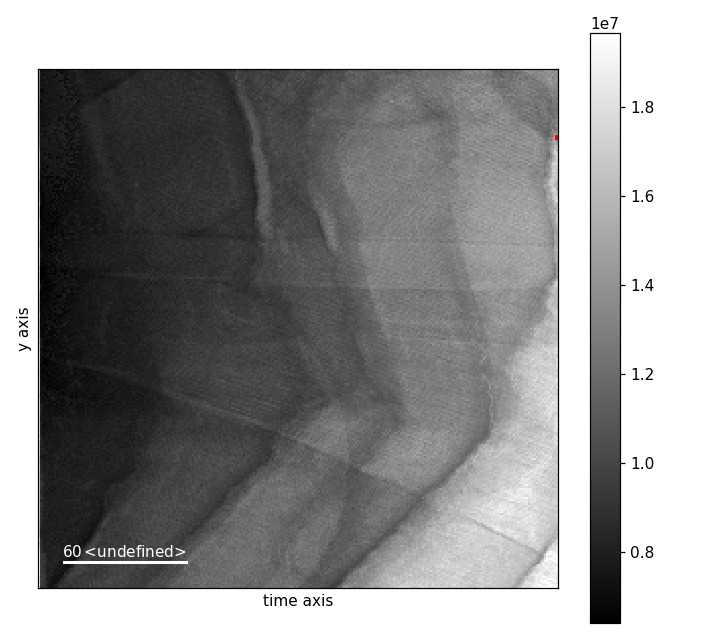

<IPython.core.display.Javascript object>


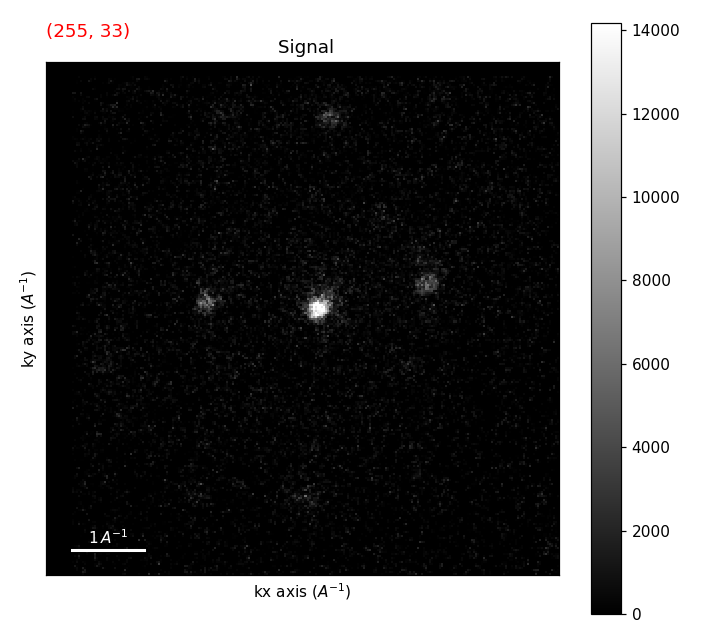

In [20]:
signal_reg.plot()

<IPython.core.display.Javascript object>


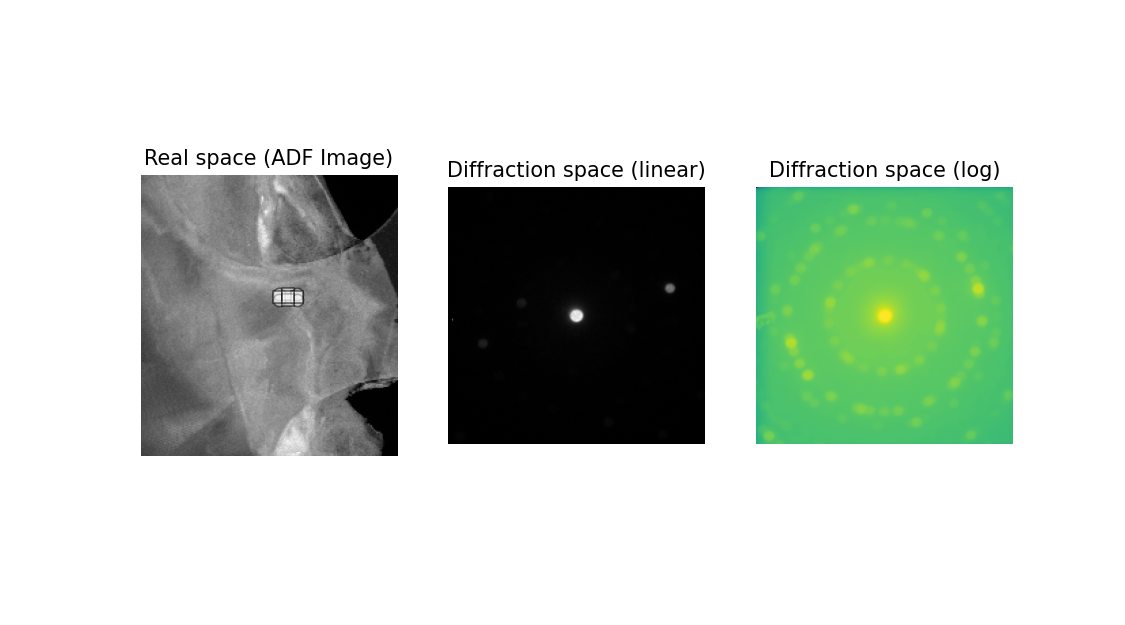

In [29]:
%matplotlib notebook
from ptycho_recon import browser
guis=browser.browser(signal_sum.inav[67:,:207].data)

In [ ]:
a = ((32,98,192,222,),(147,217,195,106)) # r = 1 # l = 3
b = ((34,106,200, 220 ),(156, 220,190, 98)) # r = 1 # l = 2
c = ((37, 113, 203,212), (164, 201, 186, 81)) # r = 3 # l = 4
d = ((42, 125, 211, 212), (173, 223, 174, 79)) # r = 6 # l = 6
e = ((51, 141, 217, 203), (185, 221, 162, 68)) # r = 6 # l = 5
f = ((74, 171, 225, 181), (207, 211, 132, 47)) # r = 6 # l = 1

<IPython.core.display.Javascript object>


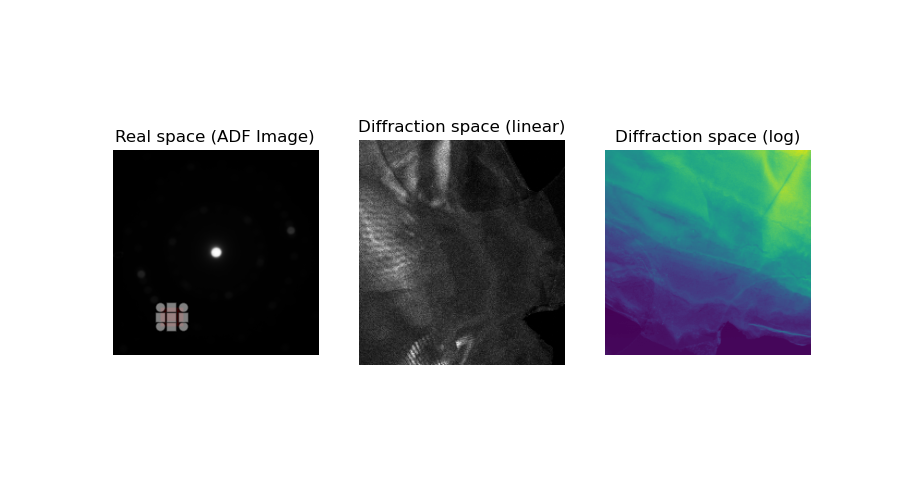

In [22]:
%matplotlib notebook
from ptycho_recon import browser
data = np.moveaxis(signal_sum.inav[67:,:207].data, [0, 1], [2, 3])
guis=browser.browser(data)

### Center zero beam in DP

In [7]:
signal_masked = signal_sum.threshold_and_mask(threshold=None, mask=(128,128,64))


  0%|          | 0/65536 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


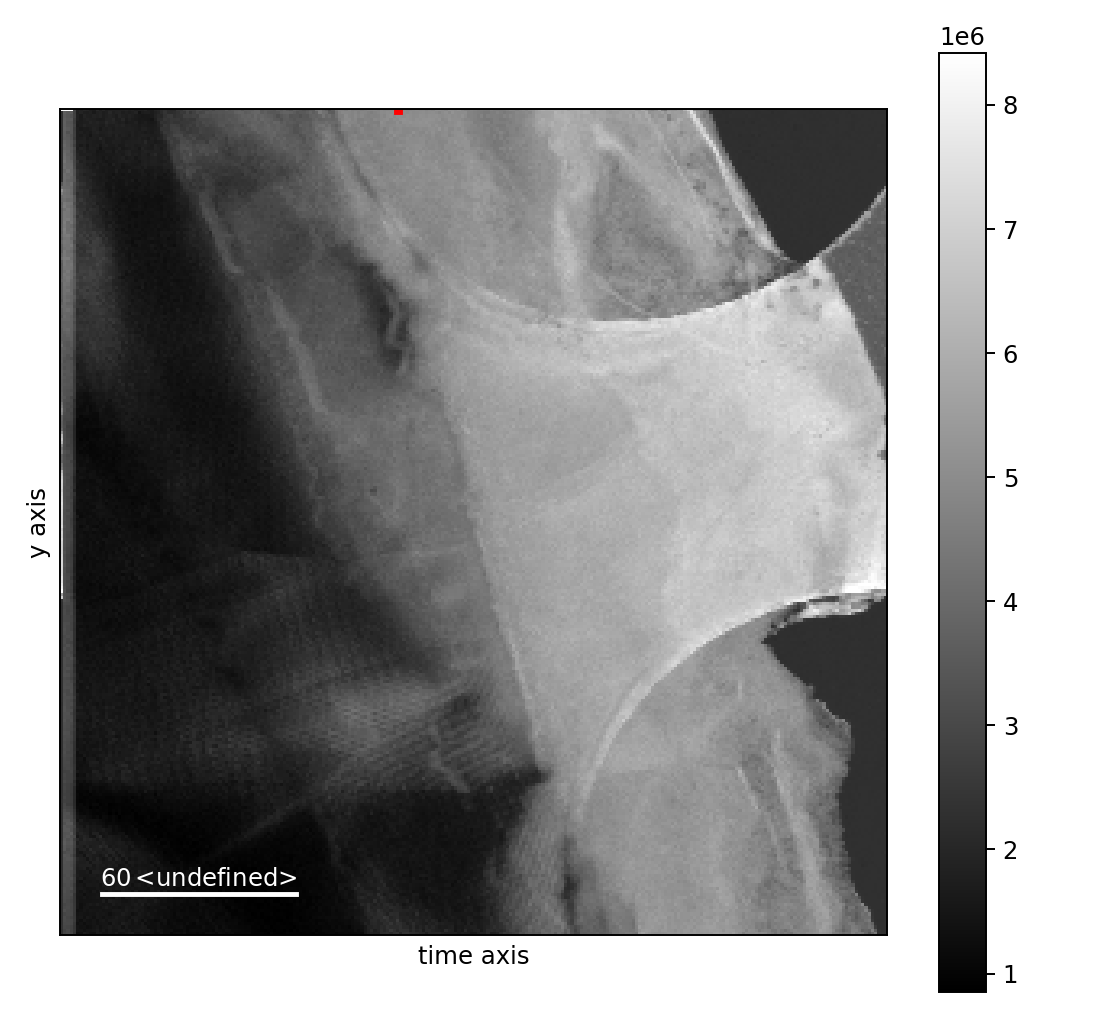

<IPython.core.display.Javascript object>


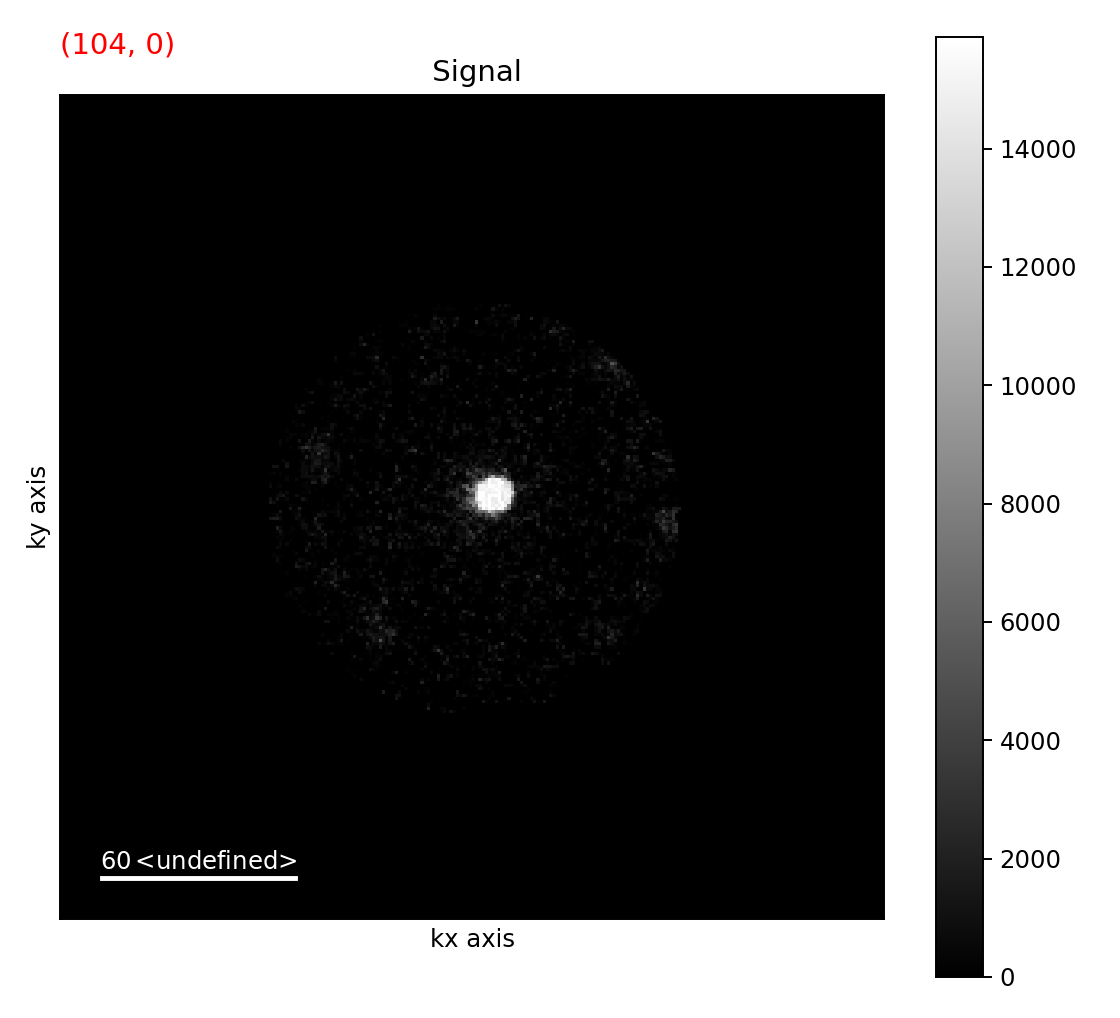

In [10]:
%matplotlib notebook
signal_masked.plot()

In [11]:
from scipy import ndimage as ndi
from skimage.feature import peak_local_max

def gaussiancenter(sample, sigma, threshold_peak):
    '''
    just gaussian blurred image max peak position
    gaussian fit is too complex 
    '''

    imgaussian = ndi.gaussian_filter(sample, sigma = sigma)
    coordinates = peak_local_max(imgaussian, min_distance = 100, threshold_abs = threshold_peak).ravel()

    if coordinates.shape[0] == 0:
        return imgaussian.shape[0]/2+1, imgaussian.shape[1]/2+1

    #plt.imshow(imgaussian)
    #plt.scatter(coordinates[1],coordinates[0], s = 1, c = 'r')
    #plt.colorbar()
    return coordinates


<IPython.core.display.Javascript object>


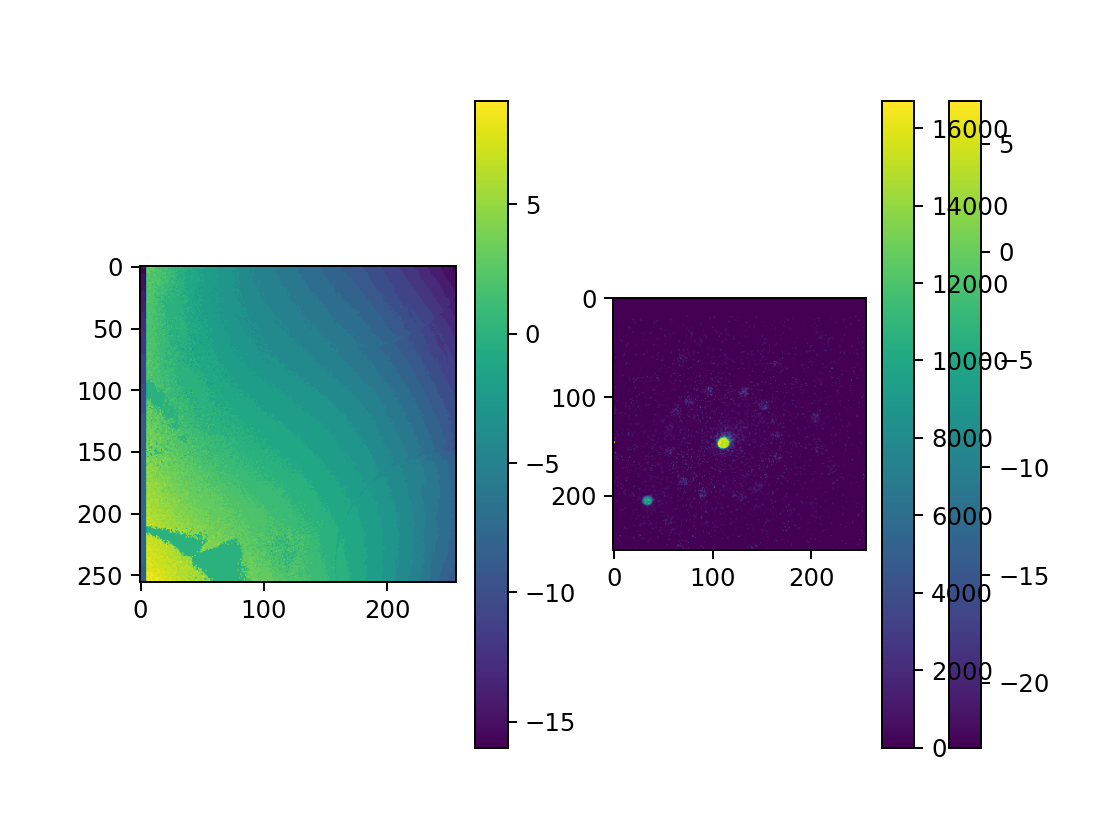

In [14]:
center = np.load(folder+'gaussiancenter.npy')
shift_x = center[:,:,0]-129
shift_y = center[:,:,1]-129
fig = plt.figure()
plt.subplot(121)
plt.imshow(shift_x)
plt.colorbar()
plt.subplot(122)
plt.imshow(shift_y)
plt.colorbar()

From the shift info above, let's just disgard the bad region that might be too thick


signal_sum.inav[67:,:207]

In [15]:

signal_reg = signal_sum.shift_diffraction(shift_x = shift_x,shift_y = shift_y,interpolation_order=1,
                                          parallel=True,inplace=False,show_progressbar=True)

  0%|          | 0/65536 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


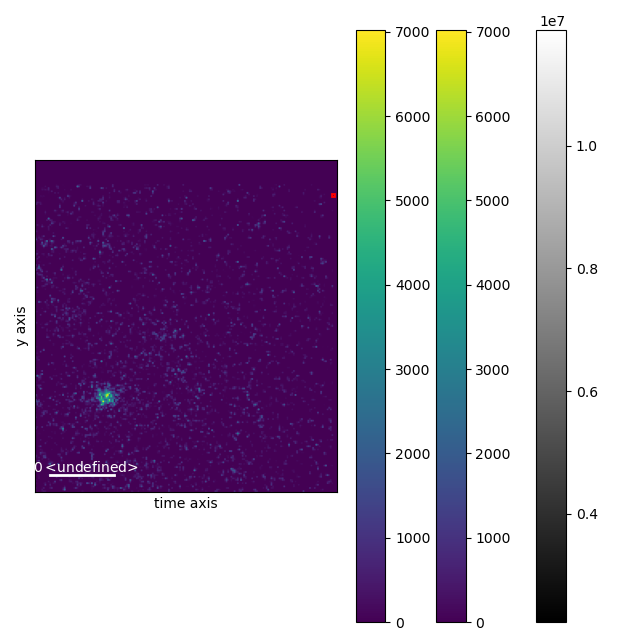

<IPython.core.display.Javascript object>


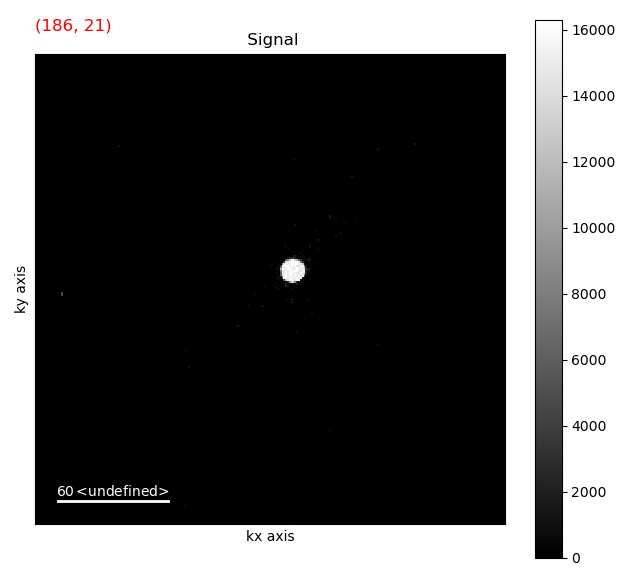

In [17]:
signal_reg.inav[67:,:207].plot()

In [7]:
#shifts = signal_sum.inav[67:, :207].get_direct_beam_position(method='blur', sigma=2, lazy_result=False)
shifts = signal_sum.inav[67:, :207].center_direct_beam(method='blur', sigma=2,return_shifts=True)

[########################################] | 100% Completed | 23.2s


pyxem center of mass works better here.

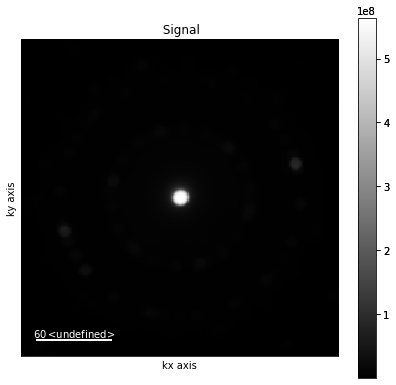

In [8]:
PACBED = signal_sum.inav[67:,:207].sum(axis = (0,1))
log = np.log(PACBED.data)
PACBED.plot()
from PIL import Image
img = Image.fromarray(PACBED.data,'F')
#img.save(folder+'pacbed.tif')

In [9]:
#signal_sum.inav[67:,:207].save(folder + 'registered_cropped.hdf5')
shifts.save(folder + 'beamcentershifts_f67_t207.hdf5')

### HAADF

<IPython.core.display.Javascript object>


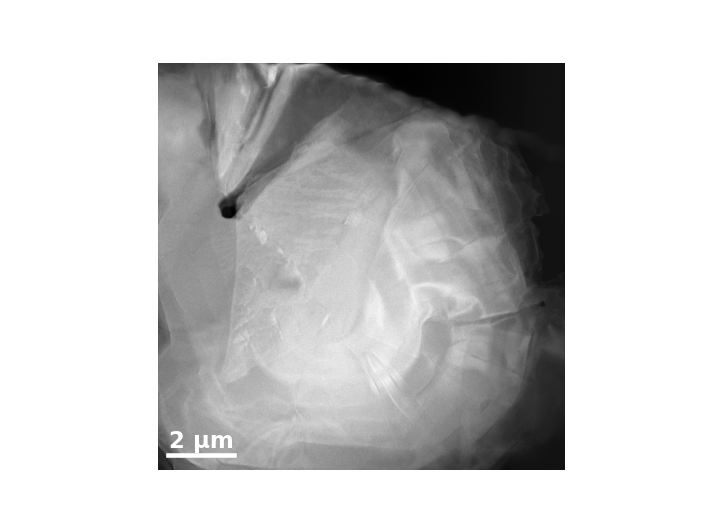

In [326]:
df = hs.load('/srv/home/jwei74/4DSTEMdata/TwistedWS2/20211204/overviewDF_1.ser')
roi = hs.load('/srv/home/jwei74/4DSTEMdata/TwistedWS2/20211204/roiDF_1.ser')
#plt.imshow(haadf.data.transpose(), cmap = 'gray')
twoum = 84*2
fig = plt.figure()
plt.imshow(df.data.transpose(), cmap = 'gray')
plt.plot([25,25+twoum],[985,985],linewidth=3, c = 'white')
plt.text(110,953,'2 µm', c = 'white',fontsize = 15,horizontalalignment='center',verticalalignment='center', weight='bold')
plt.axis('off')
fig.savefig('/srv/home/voyles/Papers/CeleritasCameraPaper/TwistedWS2_80kV/Figure/overview.tif',dpi = 300,bbox_inches='tight', edgecolor='white')

<IPython.core.display.Javascript object>


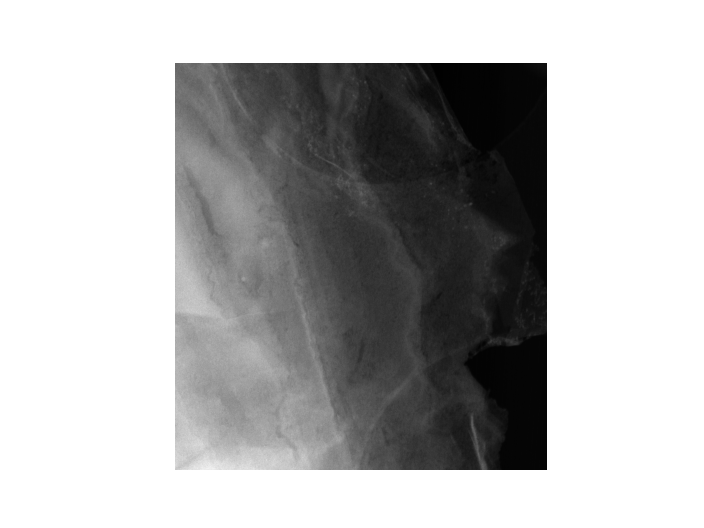

In [329]:
fig = plt.figure()
plt.imshow(roi.data[268:,:828].transpose(), cmap = 'gray')
plt.axis('off')
fig.savefig('/srv/home/voyles/Papers/CeleritasCameraPaper/TwistedWS2_80kV/Figure/roiDF.tif',dpi = 300,bbox_inches='tight', edgecolor='white')

### Labeling

<ipython-input-11-db151a2072a2>:1: RuntimeWarning: divide by zero encountered in log
  log = np.log(PACBED.data)


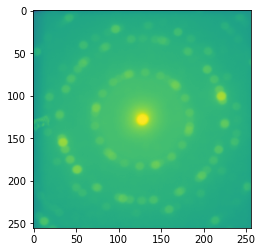

In [11]:
log = np.log(PACBED.data)
plt.imshow(log)

In [10]:
a = ((32,98,192,222,),(147,217,195,106)) # r = 1 # l = 3
b = ((34,106,200, 220 ),(156, 220,190, 98)) # r = 1 # l = 2
c = ((37, 113, 203,212), (164, 201, 186, 81)) # r = 3 # l = 4
d = ((42, 125, 211, 212), (173, 223, 174, 79)) # r = 6 # l = 6
e = ((51, 141, 217, 203), (185, 221, 162, 68)) # r = 6 # l = 5
f = ((74, 171, 225, 181), (207, 211, 132, 47)) # r = 10 # l = 1

In [25]:
#red,orange,yellow,green,cyan,blue,purple,black,white,pink
(cx, cy) = np.asarray(f)
df = np.zeros((207,189))
for spot in [0,1,2,3]:
    
    roi = hs.roi.CircleROI(cx = cx[spot],cy = cy[spot],r = 10)
    part = signal_sum.inav[67:,:207].get_integrated_intensity(roi)
    df = df  + part.data
    print('Finish spot', spot)
np.save(folder+ 'fDF.npy',df.data)

Finish spot 0
Finish spot 1
Finish spot 2
Finish spot 3


In [113]:
def enhance_contrast(image_matrix, bins=256):
    image_flattened = image_matrix.flatten()
    image_hist = np.zeros(bins)

    # frequency count of each pixel
    for pix in image_matrix:
        image_hist[pix] += 1

    # cummulative sum
    cum_sum = np.cumsum(image_hist)
    norm = (cum_sum - cum_sum.min()) * 255
    # normalization of the pixel values
    n_ = cum_sum.max() - cum_sum.min()
    uniform_norm = norm / n_
    uniform_norm = uniform_norm.astype('int')

    # flat histogram
    image_eq = uniform_norm[image_flattened]
    # reshaping the flattened matrix to its original shape
    image_eq = np.reshape(a=image_eq, newshape=image_matrix.shape)

    return image_eq

<IPython.core.display.Javascript object>


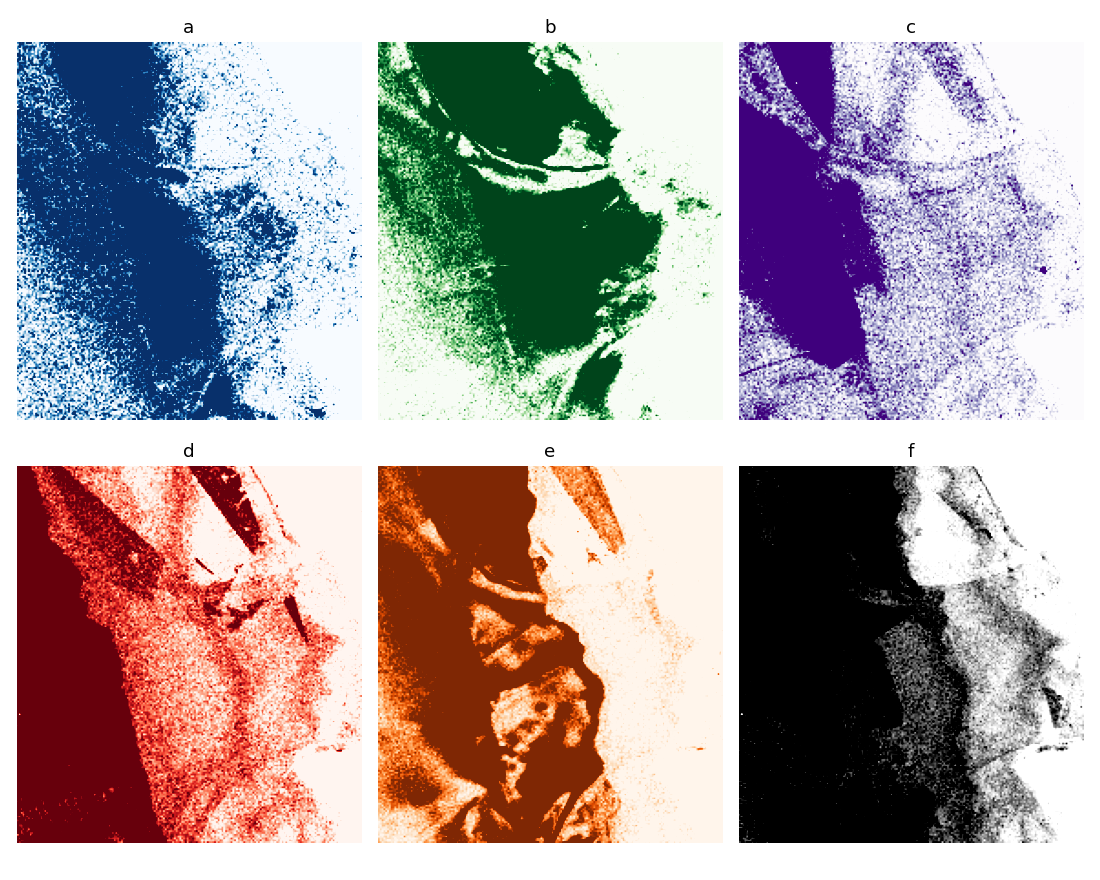

0
1
2
3
4
5


In [124]:
lis = ['a', 'b', 'c', 'd', 'e', 'f']
fig = plt.figure(figsize=(10,8))
maps =["Blues", "Greens", "Purples","Reds", "Oranges", "Greys"]

for i in range(len(color)):
    print(i)
    fig.add_subplot(2,3,i+1)
    array = np.load(folder + lis[i]+'DF.npy')
    plt.imshow(enhance_contrast(map8bit(array)), cmap = maps[i], vmax = 100, vmin = 30)

    plt.axis('off')
    plt.title(lis[i])

plt.tight_layout()

<IPython.core.display.Javascript object>


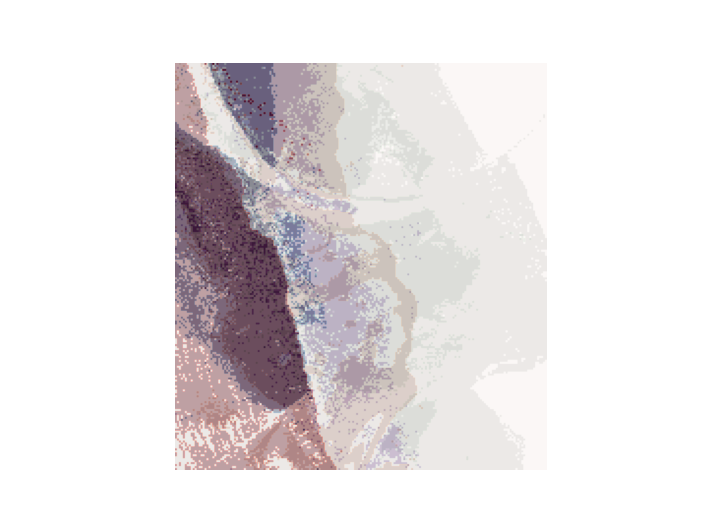

In [294]:
lis = ['a', 'b', 'c', 'd', 'e', 'f'] #4  2  5  6  3  1
maps =["Blues", "Greens", "Purples","Reds", "Oranges", "Greys"]
folder = '/srv/home/jwei74/4DSTEMdata/TwistedWS2/20211204/movie401/'
def map8bit(data):
      return ((data - data.min())/(data.max() - data.min())*255).astype('int8')

fig = plt.figure()

array = np.load(folder + 'fDF.npy')
data = enhance_contrast(map8bit(array))
data = data>10
plt.imshow(data, alpha = 0.9, cmap = 'Greys')

array = np.load(folder + 'bDF.npy')
data = enhance_contrast(map8bit(array))
data = data>110
plt.imshow(data, alpha = 0.5, cmap = 'Greens')

array = np.load(folder + 'eDF.npy')
data = enhance_contrast(map8bit(array))
data = data>110
plt.imshow(data, alpha = 0.5, cmap = 'Oranges')

array = np.load(folder + 'aDF.npy')
data = enhance_contrast(map8bit(array))
data = data>170
data[:,125:] = False
plt.imshow(data, alpha = 0.4, cmap = 'Purples')

array = np.load(folder + 'cDF.npy')
data = enhance_contrast(map8bit(array))
data = data>130
data[:,80:] = False
plt.imshow(data, alpha = 0.4, cmap = 'Blues')

array = np.load(folder + 'dDF.npy')
data = enhance_contrast(map8bit(array))
data = data>120
data[:,90:] = False
plt.imshow(data, alpha = 0.3, cmap = 'Reds')
plt.axis('off')
plt.show()

fig.savefig('/srv/home/voyles/Papers/CeleritasCameraPaper/TwistedWS2_80kV/Figure/colorlayers.tif',dpi = 300,bbox_inches='tight', edgecolor='white')

###Let's try on single frame at 10000 fps


In [271]:
folder ='/srv/home/jwei74/4DSTEMdata/TwistedWS2/20211204/movie402/'
signal = SeqIO.load_folder(folder,lazy=True, chunk_shape=(1,256,256), nav_shape=(20,256,256))
signal.data

dask.array<get_image_chunk, shape=(20, 256, 256, 256, 256), dtype=float32, chunksize=(1, 256, 256, 256, 256), chunktype=numpy.ndarray>

In [276]:
ss = signal.inav[67:,:207,1]
ss.set_signal_type('electron_diffraction') # needed
#signal_sum.set_diffraction_calibration(0.027776)
ss.compute()

[########################################] | 100% Completed | 25.7s


In [285]:
ss.center_direct_beam(method='blur', sigma=2,return_shifts=True)
ss.data[ss.data<7] = 0


[########################################] | 100% Completed | 20.6s


<Signal1D, title: , dimensions: (189, 207|2)>

In [300]:
folder = '/srv/home/jwei74/4DSTEMdata/TwistedWS2/20211204/movie402/'
(cx, cy) = np.asarray(f)
df = np.zeros((207,189))
for spot in [0,1,2,3]:
    
    roi = hs.roi.CircleROI(cx = cx[spot],cy = cy[spot],r = 10)

    part = ss.get_integrated_intensity(roi)
    df = df  + part.data
    print('Finish spot', spot)
np.save(folder+ 'fDF.npy',df.data)

Finish spot 0
Finish spot 1
Finish spot 2
Finish spot 3


<IPython.core.display.Javascript object>


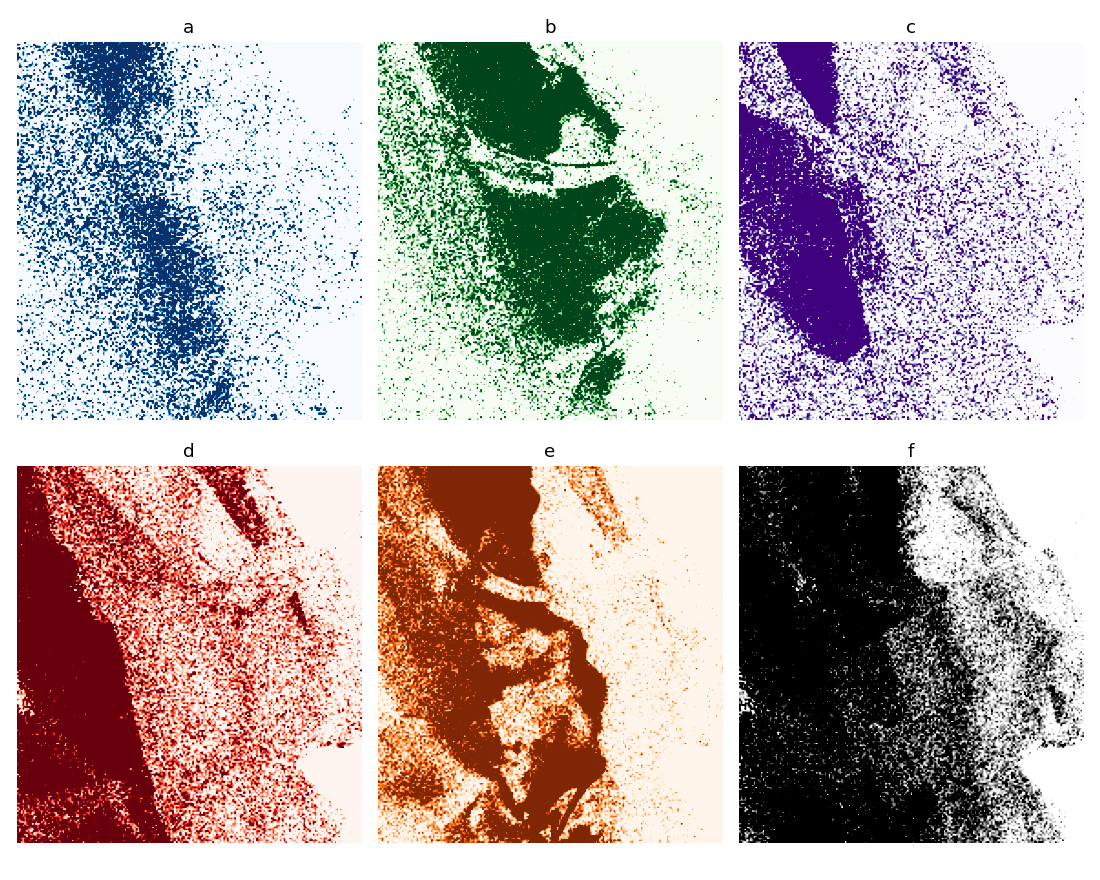

0
1
2
3
4
5


In [330]:
lis = ['a', 'b', 'c', 'd', 'e', 'f']
fig = plt.figure(figsize=(10,8))
maps =["Blues", "Greens", "Purples","Reds", "Oranges", "Greys"]

for i in range(len(color)):
    print(i)
    fig.add_subplot(2,3,i+1)
    array = np.load(folder + lis[i]+'DF.npy')
    plt.imshow(enhance_contrast(map8bit(array)), cmap = maps[i], vmax = 100, vmin = 30)

    plt.axis('off')
    plt.title(lis[i])

plt.tight_layout()

<IPython.core.display.Javascript object>


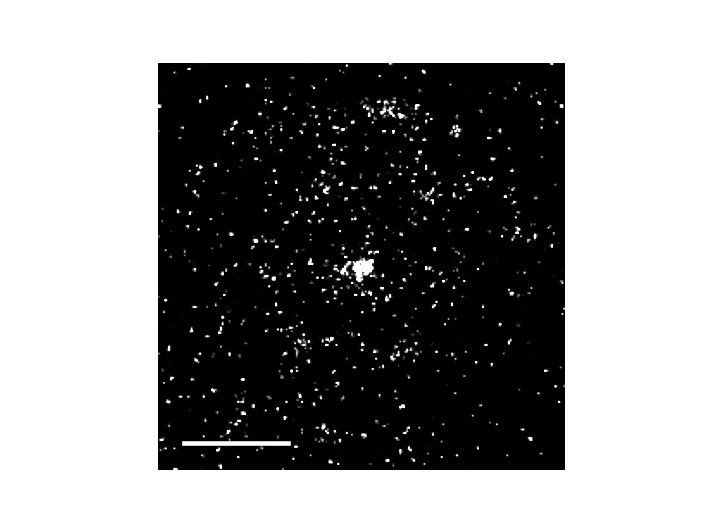

In [398]:
onemrad = 111/2/9.1838 
fig = plt.figure()
#plt.imshow(np.log(ss.data[28,92]+1), cmap = 'gray')
plt.imshow(ss.inav[10, 10].isig[10:-10,10:-10].data, cmap = 'gray', vmax = 400)

plt.axis('off')
plt.plot([15,15+onemrad*10],[220,220],linewidth=3, c = 'white')
fig.savefig('/srv/home/voyles/Papers/CeleritasCameraPaper/TwistedWS2_80kV/Figure/singleframe.tif',dpi = 300,bbox_inches='tight', edgecolor='white')

<IPython.core.display.Javascript object>


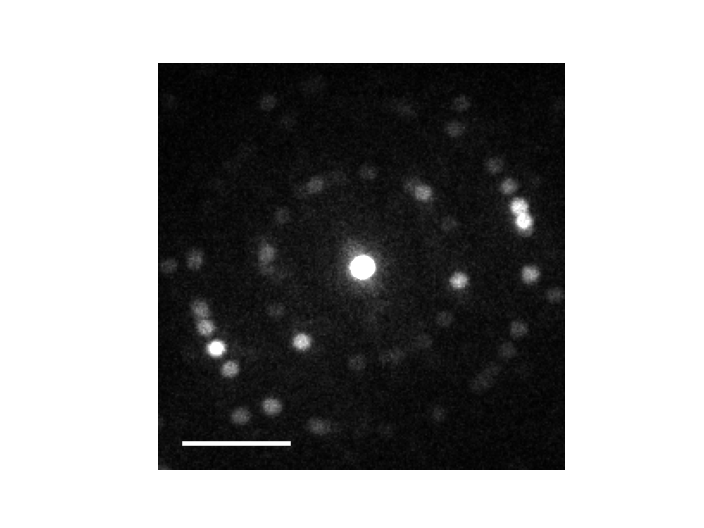

In [424]:
onemrad = 111/2/9.1838 
fig = plt.figure()
#plt.imshow(np.log(ss.data[28,92]+1), cmap = 'gray')
plt.imshow(ss.inav[20:40, 90:120].isig[10:-10,10:-10].sum(axis = (0,1)).data, cmap = 'gray', vmax = 100000)

plt.axis('off')
plt.plot([15,15+onemrad*10],[220,220],linewidth=3, c = 'white')
fig.savefig('/srv/home/voyles/Papers/CeleritasCameraPaper/TwistedWS2_80kV/Figure/redregion.tif',dpi = 300,bbox_inches='tight', edgecolor='white')

<IPython.core.display.Javascript object>


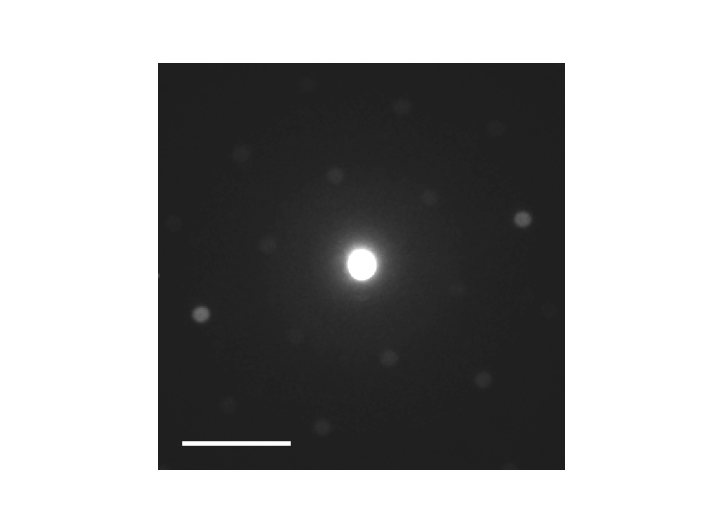

In [427]:
onemrad = 111/2/9.1838 
fig = plt.figure()
#plt.imshow(np.log(ss.data[28,92]+1), cmap = 'gray')
plt.imshow(ss.inav[130:190, 70:130].isig[10:-10,10:-10].sum(axis = (0,1)).data, cmap = 'gray', vmax = 1500000, vmin = -200000)

plt.axis('off')
plt.plot([15,15+onemrad*10],[220,220],linewidth=3, c = 'white')
fig.savefig('/srv/home/voyles/Papers/CeleritasCameraPaper/TwistedWS2_80kV/Figure/grayregion.tif',dpi = 300,bbox_inches='tight', edgecolor='white')